## Обнаружение объектов (Object Detection)

### Наивный подход к обнаружению объектов

* Разбить изображение на фрагменты
* Пропустить фрагменты через CNN для классификации
* Выбрать те фрагменты, в которых наблюдается достаточно высокие значения вероятности классификатора

In [11]:
import cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

Рассмотрим пример изображения девочки с кошкой. Дополним изображение до квадратного для простоты.

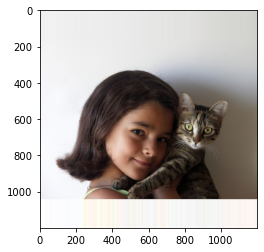

In [19]:
img = cv2.imread('images/1200px-Girl_and_cat.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = np.pad(img,((158,158),(0,0),(0,0)),mode='edge')
plt.imshow(img)

Будем использовать предварительно обученную сеть VGG-16:

In [14]:
vgg = keras.applications.vgg16.VGG16(weights='imagenet')

Определим функцию, которая будет предсказывать вероятность кошки на изображении. Поскольку ImageNet содержит ряд классов для кошек с индексами от 281 до 294, мы просто сложим вероятности для этих классов, чтобы получить общую вероятность для кошки:

In [15]:
def predict(img):
  im = cv2.resize(img,(224,224))
  im = keras.applications.vgg16.preprocess_input(im)
  pr = vgg.predict(np.expand_dims(im,axis=0))[0]
  return np.sum(pr[281:294]) # классы для кошек - от 281 до 294

predict(img)

0.61825

Теперь разделим изображение на квадраты $n\times n$ и построим тепловую карту вероятностей:

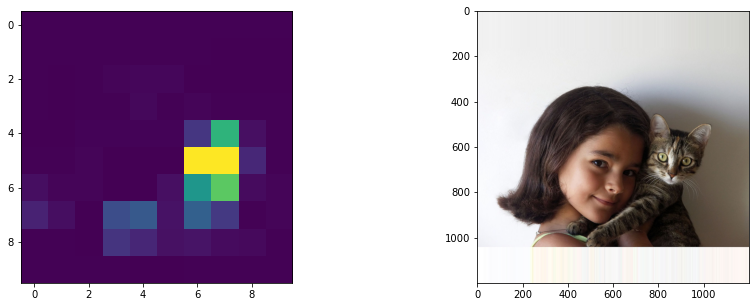

In [20]:
def predict_map(img,n):
  dx = img.shape[0] // n
  res = np.zeros((n,n),dtype=np.float32)
  for i in range(n):
    for j in range(n):
      im = img[dx*i:dx*(i+1),dx*j:dx*(j+1)]
      r = predict(im)
      res[i,j] = r
  return res

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[1].imshow(img)
ax[0].imshow(predict_map(img,10))

## Обнаружение простых объектов

Этот пример показывает главный принцип, но он позволяет обнаруживать объект с точностью до квадрата 224x224 пикселя (или точнее, но при этом число запусков нейросети будет очень большим).

Чтобы получить более точное расположение ограничительной рамки, нужно использовать **регрессионную модель** для прогнозирования её координат. Начнем с простого примера обнаружения черных прямоугольников в изображениях 8x8. Идея и некоторый код заимствованы из [этой заметки](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491).

![](images/rect_det.png)

Следующая функция сгенерирует множество примеров изображений с известными рамками:

In [113]:
def generate_images(num_imgs, img_size=8, min_object_size = 1, max_object_size = 4):
    bboxes = np.zeros((num_imgs, 4))
    imgs = np.zeros((num_imgs, img_size, img_size))  # цвета фона - 0

    for i_img in range(num_imgs):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # цвет внутри прямоугольника - 1
        bboxes[i_img] = [x, y, w, h]
    return imgs, bboxes

imgs, bboxes = generate_images(100000)
print(f"Images shape = {imgs.shape}")
print(f"BBoxes shape = {bboxes.shape}")

Images shape = (100000, 8, 8)
BBoxes shape = (100000, 4)


Чтобы сделать выходы сети в диапазоне [0;1], мы разделим `bboxes` на размер изображения:

In [114]:
bb = bboxes/8.0
bb[0]

array([0.   , 0.25 , 0.125, 0.25 ])

В нашем простом примере мы будем использовать полносвязную нейронную сеть. В реальной жизни, когда объекты имеют более сложную форму, определенно имеет смысл использовать свёрточную архитектуру. В качестве метрик мы будем использовать среднеквадратичное отклонение (MSE), поскольку мы решаем задачу регрессии, и оптимизатор стохастического градиентного спуска.

In [144]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(8,8)),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4)
])
model.compile('sgd','mse')
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 200)               13000     
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_51 (Dense)            (None, 4)                 804       
                                                                 
Total params: 13,804
Trainable params: 13,804
Non-trainable params: 0
_________________________________________________________________


Обучим нашу сеть. Мы также нормализуем входные данные (путем вычитания среднего и деления на стандартное отклонение) для немного лучшей производительности.

In [145]:
imgs_norm = (imgs-np.mean(imgs))/np.std(imgs)
model.fit(imgs_norm,bb,epochs=30)

Epoch 1/30
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0562
Epoch 2/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0131
Epoch 3/30
3125/3125 [==============================] - 5s 1ms/step - loss: 0.0076
Epoch 4/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0058
Epoch 5/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0050
Epoch 6/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0044
Epoch 7/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0041
Epoch 8/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0038
Epoch 9/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0036
Epoch 10/30
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0034
Epoch 11/30
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0033
Epoch 12/30
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0031
E

Функция потерь достаточно мала. Посмотрим, как это отражается в метриках, которые обычно используются при обнаружении объктов. Обычно это метрика **mean average precicion** (mAP). Чтобы понять эту метрику, сначала опишем функцию, вычисляющую метрику **IOU** (Intersection over Union) между двумя ограничительными рамками:

In [146]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

Теперь мы сгенерируем 500 тестовых изображений и построим первые 5 из них, чтобы визуализировать, насколько мы точны. Мы также распечатаем метрику IOU:

pred=[3.7325673 3.6551285 2.0126944 1.030895 ],act=[4. 4. 2. 1.], IOU=0.41607480412565545
pred=[2.3762555 3.755858  1.1647941 1.0540264],act=[2. 4. 1. 1.], IOU=0.2932611042051458
pred=[-0.04900682 -0.10628867  2.7881489   1.027148  ],act=[0. 0. 3. 1.], IOU=0.7548650953478908
pred=[0.96806276 4.267275   1.3179774  1.1021365 ],act=[0. 5. 1. 1.], IOU=0.004833667961256898
pred=[2.157959   0.94667876 2.7568097  0.96259   ],act=[2. 1. 3. 1.], IOU=0.7965311752734529


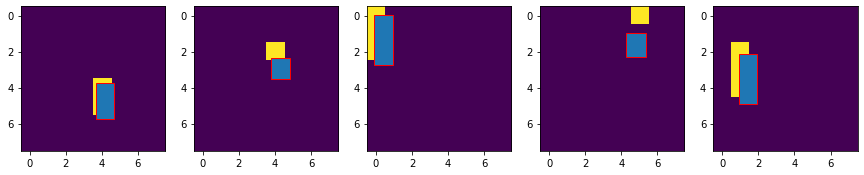

In [149]:
import matplotlib

test_imgs, test_bboxes = generate_images(500)
bb_res = model.predict((test_imgs-np.mean(imgs))/np.std(imgs))*8

plt.figure(figsize=(15,5))
for i in range(5):
    print(f"pred={bb_res[i]},act={test_bboxes[i]}, IOU={IOU(bb_res[i],test_bboxes[i])}")
    plt.subplot(1,5,i+1)
    plt.imshow(test_imgs[i])
    plt.gca().add_patch(matplotlib.patches.Rectangle((bb_res[i,1],bb_res[i,0]),bb_res[i,3],bb_res[i,2],ec='r'))
    #plt.annotate('IOU: {:.2f}'.format(IOU(bb_res[i],test_bboxes[i])),(bb_res[i,1],bb_res[i,0]+bb_res[i,3]),color='y')


Чтобы вычислить итоговую метрику, нам нужно рассчитать и усреднить IOU по всем тестовым примерам. Если же в задаче обнаружения объектов есть несколько классов - то mAP необходимо усреднить и по этим классам.

In [151]:
np.array([IOU(a,b) for a,b in zip(test_bboxes,bb_res)]).mean()

0.7150587956049862

## Задачи обнаружения объектов в реальной жизни

Реалистичные алгоритмы обнаружения объектов более сложны. Одним из хорошо зарекомендовавших себя алгоритмов является RetinaNet.

Хороший пример object detection содержится в [руководстве Keras по обнаружению объектов с помощью RetinaNet](https://keras.io/examples/vision/retinanet/), если вы хотите получить подробное представление о реализации RetinaNet, или использовать [Keras RetinaNet Library](https://github.com/fizyr/keras-retinanet), если вы просто хотите обучить модель обнаружения объектов.